<a href="https://colab.research.google.com/github/manualAlan/ComPhys/blob/main/FluidDynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://courses.physics.illinois.edu/phys246/fa2022/img/FD_intro.png" width=1000 align=left></img><br>

# Fluid Dynamics

* **Author:**

* **Date:**

* **Time spent on this assignment:**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.animation import FuncAnimation
import itertools
from IPython.display import HTML
import pickle
from numba import jit
def resetMe(keepList=[]):
    ll=%who_ls
    keepList=keepList+['resetMe','np','plt','math','FuncAnimation',
                       'HTML','itertools','pickle','testFunc']
    for iiii in keepList:
        if iiii in ll:
            ll.remove(iiii)
    for iiii in ll:
        jjjj="^"+iiii+"$"
        %reset_selective -f {jjjj}
    ll=%who_ls
    return

def testFunc(func,inFiles,outFiles):
    inputs  = [pickle.load(open(f,"rb")) for f in inFiles]
    outputs = [pickle.load(open(f,"rb")) for f in outFiles]
    result  = func(*inputs)
    allGood = True
    if not isinstance(result, tuple): result = (result,)
    for i in range(len(outputs)):
        if np.max(np.abs(result[i]-outputs[i])) > 1e-14:
            print("Failed test for",outFiles[i],i,np.max(np.abs(result[i]-outputs[i])))
            allGood = False
    if allGood: print("Test Passed!")
    else:       print("Test Failed :(")


Download the test files here, or download from the website and upload & unzip them to wherever this notebook file is

In [ ]:
!wget https://courses.physics.illinois.edu/phys246/fa2020/code/TestFiles.zip && unzip TestFiles.zip

--2022-11-13 00:18:01--  https://courses.physics.illinois.edu/phys246/fa2020/code/TestFiles.zip
Resolving courses.physics.illinois.edu (courses.physics.illinois.edu)... 130.126.151.14
Connecting to courses.physics.illinois.edu (courses.physics.illinois.edu)|130.126.151.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53041362 (51M) [application/x-zip-compressed]
Saving to: ‘TestFiles.zip.2’

TestFiles.zip.2     100%[===================>]  50.58M  43.3MB/s    in 1.2s    

2022-11-13 00:18:02 (43.3 MB/s) - ‘TestFiles.zip.2’ saved [53041362/53041362]

Archive:  TestFiles.zip
replace Microscopic_after_move.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Python Warmup

### Useful functions:

Before we begin, we want to highlight some functions that you may find useful in this assignment. The last one we'll explore in more depth as well.
* `np.zeros([dimensions])` - create an array filled with all zeros.
    *Ex: `n = np.zeros([9,10,10])` creates a (9,10,10) array of all zeros
* `np.ones([dimensions])` - same thing as `np.zeros` but with all ones.
* `np.empty([dimensoons])` - same thing as `np,zeros` but fills array with garbage. Very fast compared to the above.
* `np.roll(x,shift,axis)` - shift array `x` by `shift` along `axis`.

### Warmup - using `np.roll`

Something we'll see later in this assignment is the need to shift elements right,left,up,down, and diagonally. Let's make a little test problem to illustrate how this works.

In [ ]:
# Run me!
x = np.arange(15).reshape(3,5)
print(x)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]]


Now we'll want to shift every element in `x` to the right, where we wrap everything around the edge. Rather than figuring this out with a for loop, we'll employ `np.roll` to do it fast!

In [ ]:
print(x,'\n')
print(np.roll(x,(0,1),(0,1)))

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]] 

[[ 4  0  1  2  3]
 [ 9  5  6  7  8]
 [14 10 11 12 13]]


Now let's disect that command. The first `(0,1)` means don't shift the "y" direction, and to shift the "x" direction by +1. The next command `(0,1)` means to apply the shift to the two axes.  
Now let's go left:

In [ ]:
print(x,'\n')
print(np.roll(x,(0,-1),(0,1)))

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]] 

[[ 1  2  3  4  0]
 [ 6  7  8  9  5]
 [11 12 13 14 10]]


---
🦉 Now we'll try to implement a section of the Cha-Cha Slide([Lyrics](https://genius.com/Dj-casper-cha-cha-slide-lyrics))
```
♫Now it's time to get funky
To the right now, to the left
Take it back now y'all♪
```

Make your `x` array go right, then left, then "down". Your output should be:
```
[[ 4  0  1  2  3]
 [ 9  5  6  7  8]
 [14 10 11 12 13]]
[[ 1  2  3  4  0]
 [ 6  7  8  9  5]
 [11 12 13 14 10]]
[[ 5  6  7  8  9]
 [10 11 12 13 14]
 [ 0  1  2  3  4]]
```
(Notice how down isn't what you may expect...)

In [ ]:
#!Start
print(np.roll(x,(0,1),(0,1)))
print(np.roll(x,(0,-1),(0,1)))
print(np.roll(x,(-1,0),(0,1)))
#!Stop

[[ 4  0  1  2  3]
 [ 9  5  6  7  8]
 [14 10 11 12 13]]
[[ 1  2  3  4  0]
 [ 6  7  8  9  5]
 [11 12 13 14 10]]
[[ 5  6  7  8  9]
 [10 11 12 13 14]
 [ 0  1  2  3  4]]


🦉In a special version of the song, the next line goes
```
♫ Take it diagonally up and to the right now y'all
```
Implement this array move, you should get:
```
[[14 10 11 12 13]
 [ 4  0  1  2  3]
 [ 9  5  6  7  8]]
 ```

Now you're a ~~Cha-Cha Slide~~ `np.roll` master!

## Exercise 1: Fluid Dynamics

* **List of collaborators:**

* **References you used in developing your code:**

In this assignment you will produce a fluid dynamics simulations.  We are going to develop a number of functions which you will store in the cell below (as well as some global variables that we will use throughout this exercise).

The global variables are
```python
nx=520; ny=180 #size of our simulation
```


<img src="https://courses.physics.illinois.edu/phys246/fa2022/img/AnsStart.svg" width=200 align=left></img><br>

In [ ]:
### ANSWER HERE
nx=520
ny=180


<img src="https://courses.physics.illinois.edu/phys246/fa2022/img/AnsEnd.svg" width=200 align=left></img><br>

<div class="alert alert-danger" style="color:black">

If you have a function that takes in an array <code>n</code>, always make a new variable to return:
```python
def doMath(n):
    # nout = n.copy() #notice the .copy(), so that they aren't the same object
    nout = 2*n+5
    return nout
```

</div>

### a.  Making some obstacles

To simulate the real world on the computer, we'll break the tunnel into $n_x\times n_y$ squares which we'll call *voxels*.  


Your simulation will be doing fluid dynamics in a $n_x \times n_y$ "tunnel" which has some objects within it.  These objects will be represented by a boolean $n_x \times n_y$ size array `obstacle=np.empty((nx,ny),dtype='bool')` which should be `True` where the obstacle is and `False` otherwise. For example,
```python
obstacle[:,:]=False
obstacle[50:70,50:70]=True
```
would set up a square $20 \times 20$ object inside our tunnel.

🦉Add a `GenerateCylinderObstacle()`  function to the "function-cell" above which generates a object which is a cylinder located at $(n_x/4,n_y/2)$ with a radius of $n_y/9$

If you do `plt.matshow(GenerateCylinderObstacle())` it should look like this

<img src="https://courses.physics.illinois.edu/phys246/fa2022/img/FDObstacle.png" width=1000 align=left></img><br>

In [ ]:

def GenerateCylinderObstacle():
  obstacle=np.empty((nx,ny),dtype='bool')
  obstacle[:,:]=False
  cx = nx/4
  cy = ny/2
  for i in range(0, nx):
    for j in range(0, ny):
      r = ((cx-i)**2+(cy-j)**2)**(1/2)
      if (r < ny/9):
        obstacle[i,j] = True
  return obstacle
#obstacle = GenerateCylinderObstacle()


<div class="alert alert-warning" style="color:black">
<b>Do not use the word <code>object</code> as a variable!</b> <br />Notice how <code>object</code> is green in a cell - this means it is a special keyword.<br />
</div>

#### Test:

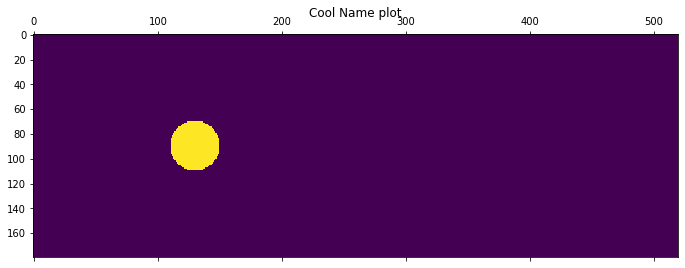

In [ ]:
## Call your function here to see if if works.
plt.matshow(GenerateCylinderObstacle().transpose())
plt.title("Cool Name plot")
#plt.savefig("images/object.png")
plt.show()


## b.  Microscopic velocities $v_i$

To simulate the real world on the computer, we'll break the tunnel into $n_x\times n_y$ squares which we'll call *voxels*.

The key quantity in your simulation is  nine microscopic degrees of freedom
* $n_k(i,j)$ where $0\leq k \leq 8$ and $(i,j)$ are over the $n_x \times n_y$ voxels of your simulation

which are going to be nine different densities (for each voxel $(i,j)$) which correspond to the density of a fluid at $(i,j)$ moving in nine different directions (or velocities $v_k$):
* $n_0$: stationary fluid moving at velocity $v_0=(0,0)$
* $n_1$: fluid moving up moving at velocity $v_1=(0,1)$
* $n_2$: fluid moving down at velocity $v_2=(0,-1)$
* $n_3$: fluid moving right at velocity $v_3=(1,0)$
* $n_4$: fluid moving left at velocity $v_4=(-1,0)$
* $n_5$: fluid moving left-down at velocity $v_5=(-1,-1)$
* $n_6$: fluid moving left-up at velocity $v_6=(-1,1)$
* $n_7$: fluid moving right-down at velocity $v_7=(1,-1)$
* $n_8$: fluid moving right-up at velocity $v_8=(1,1)$
    
It will be useful to have access to these microscopic velocities as global variables.  🦉**Go ahead and add to the top of your "function-cell" the various velocities:**
```python
v=np.zeros((9,2),dtype='int')
v[0,:]=[0,0]
v[1,:]=[0,1]
...
```

**Plot these (below) as**
```python
for i in range(0,9):
    plt.arrow(0,0,v[i,0],v[i,1],head_width=0.05, head_length=0.1, fc='k', ec='k')
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
plt.show()
```
and make sure it looks like

<img src="https://courses.physics.illinois.edu/phys246/fa2022/img/FD_direction.png" width=400 align=left></img><br>

In [ ]:
v=np.zeros((9,2),dtype='int')
v[0,:]=[0,0]
v[1,:]=[0,1]
v[2,:]=[0,-1]
v[3,:]=[1,0]
v[4,:]=[-1,0]
v[5,:]=[-1,-1]
v[6,:]=[-1,1]
v[7,:]=[1,-1]
v[8,:]=[1,1]


#### Test:

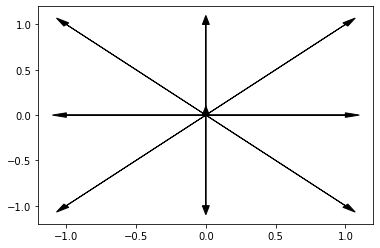

In [ ]:
## Plot your microscopic velocities

for i in range(0,9):
    plt.arrow(0,0,v[i,0],v[i,1],head_width=0.05, head_length=0.1, fc='k', ec='k')
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
#plt.savefig("images/densityDirection.png")
plt.show()

We will represent the microscopic densities by a variable
* `n=np.zeros(9,nx,ny)`


The high level algorithm for fluid dynamics is very simple.  After setting up the initial conditions, we loop many times doing
* Adjust boundary conditions
* Collide the microscopic densities
* Move the microscopic densities


### c. Computing macroscopic quantities from the microscopic density

Given the microscopic densities, there are two macroscopic quanties:
* the macroscopic density $\rho(i,j)=\sum_k n_k$ (*size: $n_x \times n_y$*)
* the macroscopic velocity $\vec{u}(i,j) \equiv (u_x(i,j),u_y(i,j)$ (*size: $2 \times n_x \times n_y$*) where
    * $u_x(i,j) = 1/\rho \sum_k v_{k,x}\, n_k(i,j)$
    * $u_y(i,j) = 1/\rho \sum_k v_{k,y}\, n_k(i,J)$

which you will compute using the function (you will write) `(rho,u) = Micro2Macro(n)`

🦉Go ahead and write this function and add it to your 'function-cell'

You can test it using these lines of code:
```python
testFunc(Micro2Macro,["Microscopic.dat"],["rho_after_Micro2Macro.dat","u_after_Micro2Macro.dat"])
```
and see if it print two zeros (which is a success!)

**Tip:** Because `u` is $(2,n_x,n_y)$, we can get `ux` by doing `u[0]` (which is then a $(n_x,n_y)$ array) and `uy` by doing `u[1]`.

In [ ]:
@jit
def Micro2Macro(n):
  rho = np.zeros((nx,ny))
  u = np.zeros((2,nx,ny))
  for i in range(nx):
    for j in range(ny):
      rho[i,j]=sum(n[:,i,j])
      for k in range(9):
        x = v[k]
        u[0,i,j]+=x[0]*n[k,i,j]
        u[1,i,j]+=x[1]*n[k,i,j]
      u[:,i,j]=u[:,i,j]/rho[i,j]
  return rho, u




#### optional - `np.einsum`

Figuring out the summations effeciently can be a pain, but we can use [`np.einsum`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.einsum.html) help out here. Figure out how to rewrite the above problem with einstein summation notation. To use the function, if we have
$$
A_{ijk}\cdot B_{dk} = C_{ijd},
$$
we'd use then call:
```python
C = np.einsum("ijk,dk->ijd",A,B)
```

#### Test:

In [ ]:
#!Start
#import pickle
#np.random.seed(30)
#microscopicDensity=np.random.random((9,nx,ny))
#pickle.dump( microscopicDensity, open( "Microscopic.dat", "wb" ) )
#(rho,u)=Micro2Macro(microscopicDensity)
#pickle.dump( rho, open( "rho_after_Micro2Macro.dat", "wb" ) )
#pickle.dump( u, open( "u_after_Micro2Macro.dat", "wb" ) )
#!Stop
testFunc(Micro2Macro,["Microscopic.dat"],["rho_after_Micro2Macro.dat","u_after_Micro2Macro.dat"])

Test Passed!


### d. Getting the equilibrium microscopic densities.


Given the macroscopic densities $\rho$ and $\vec{u}$, there is a *equilibrium* microscopic densities $n_{eq}$ (*size: $9 \times n_x \times n_y$*) which you will compute using `n_eq=Macro2Equilibrium(rho,u,obstacle)`

The relevant formula for this is

$$ n^{eq}(v_k) \equiv n_k^{eq} =  \omega_k \rho \left(1 + 3 \vec{v_k} \cdot \vec{u} + \frac{9}{2}(\vec{v_k} \cdot \vec{u})^2- \frac{3}{2}(\vec{u}\cdot \vec{u}) \right)  \tag{A} $$

where
* $\omega_{0}=4/9$
* $\omega_{1-4}=1/9$
* $\omega_{5-8}=1/36$

Given some microscopic densities $n$ you should be able then to figure out the equilibrium microscopic densities $n_{eq}$.  

🦉Write the functions `Macro2Equilibrium` adding them to your "function-cell"

You can test it by checking if
```python
testFunc(Macro2Equilibrium,["rho_after_Micro2Macro.dat","u_after_Micro2Macro.dat"],["Microscopic_after_equilibrium.dat"])
```
is equal to zero.

In [ ]:
def Macro2Equilibrium(rho,u):
  ns = np.zeros((9,nx,ny))
  for i in range(nx):
    for j in range(ny):
      for k in range(9):
        if (k==0):
          omega = 4/9
        elif (k<=4):
          omega = 1/9
        else:
          omega = 1/36
        ns[k,i,j]=omega*rho[i,j]*(1+3*np.dot(v[k],u[:,i,j])+9/2*(np.dot(v[k],u[:,i,j]))**2-3/2*np.dot(u[:,i,j],u[:,i,j]))
  return ns

#### Test:

In [ ]:
#pickle.dump( microscopicDensity, open( "Microscopic_after_equilibrium.dat", "wb" ) ) #!#
testFunc(Macro2Equilibrium,["rho_after_Micro2Macro.dat","u_after_Micro2Macro.dat"],["Microscopic_after_equilibrium.dat"])


Test Passed!


### d. Implementing collision

Once you can compute these quantities, the next step is to implement the collision step.  

🦉Write a function `Collision(n,obstacle)` which returns the density `n` after collision.  Put it in your function-cell above.


When we collide the microscopic densities, we get new microscopic densities given as  
* `nout = n * (1-omega) + omega * neq`

Here are the steps for the function:
1. Calculate `neq`  
    a. take the microscopic densities $\rightarrow$ compute the macroscopic density and velocity `(rho,u) = Micro2Macro(n)`  
    b. take the macroscopic density and velocity $\rightarrow$ compute the equilibrium microscopic densities `neq=Macro2Equilibrium(rho,u)`  
2. Calculate `nout = n * (1-omega) + omega * neq`   
    a. $\omega$ is the viscosity parameter.  We will use $\omega =1.9572953736654806$
3. We moved fluid where the obstacle is, so we need to undo this. Reset all `nout` where the obstacle is to be the same as `n`



Test with
```python
testFunc(lambda x: Collision(x,GenerateCylinderObstacle()),["Microscopic.dat"],["Microscopic_after_collision.dat"])
```


In [ ]:
@jit
def Collision(n,obstacle):
  omega = 1.9572953736654806
  rho, u = Micro2Macro(n)
  neq = Macro2Equilibrium(rho,u)
  nout = n.copy()
  for i in range(nx):
    for j in range(ny):
      if obstacle[i,j]== False:
        nout[:,i,j]=n[:,i,j]*(1-omega)+omega*neq[:,i,j]
  return nout

#### Test:

In [ ]:
#pickle.dump( Collision(microscopicDensity,GenerateCylinderObstacle()), open( "Microscopic_after_collision.dat", "wb" ) ) #!#

testFunc(lambda x: Collision(x,GenerateCylinderObstacle()),["Microscopic.dat"],["Microscopic_after_collision.dat"])

Test Passed!


### e. Moving

We'll now move on to getting the fluid to move. This will be a function called, surprise, `Move(n,obstacle)`. But first we need to helper functions:
* `Bounce(n,obstacle)`
    * bounce the velocities - that is every velocity where the obstacle is gets reversed
* `MoveDensity(n)`
    * Move all your densities in the direction of the velocity (*hint* the velocity tells you where to move it)
    * Assume periodic boundary conditions here

Thus a `Move(n,obstacle)` call is just a `Bounce` then `MoveDensity`. 🦉Write this function and test!


Test:
```python
testFunc(lambda x: Bounce(x,GenerateCylinderObstacle()),["Microscopic.dat"],["Microscopic_after_bounce.dat"])

testFunc(MoveDensity,["Microscopic.dat"],["Microscopic_after_moveDensity.dat"])

testFunc(lambda x: Move(x,GenerateCylinderObstacle()),["Microscopic.dat"],["Microscopic_after_move.dat"])
```

In [ ]:
@jit
def Bounce(n,obstacle):
  #nout = Collision(n,obstacle)
  nout = n.copy()
  for i in range(nx):
    for j in range(ny):
      if (obstacle[i,j]==True):
        nout[1,i,j]= n[2,i,j]
        nout[2,i,j]= n[1,i,j]
        nout[3,i,j]= n[4,i,j]
        nout[4,i,j]= n[3,i,j]
        nout[6,i,j]= n[7,i,j]
        nout[7,i,j]= n[6,i,j]
        nout[5,i,j]= n[8,i,j]
        nout[8,i,j]= n[5,i,j]
  return nout
@jit
def MoveDensity(n):
  nout = np.empty((9,nx,ny))
  for i in range(len(n)):
    nout += np.roll(n[i],v[i],axis=(0,0))
  return nout
@jit
def Move(n, obstacle):
  no = MoveDensity(Bounce(n,obstacle))
  return no



#### Tests:

In [ ]:
#!Start
#pickle.dump( MoveDensity(microscopicDensity), open( "Microscopic_after_moveDensity.dat", "wb" ) )
##pickle.dump( MoveDensity(microscopicDensity,GenerateCylinderObstacle()), open( "Microscopic_after_collision.dat", "wb" ) )
##print(np.max(np.abs(Collision(microscopicDensity,GenerateCylinderObstacle())-pickle.load( open( "Microscopic_after_collision.dat", "rb" ) ))))
#microscopicDensity=pickle.load( open( "Microscopic.dat", "rb" ) )
#pickle.dump( Bounce(microscopicDensity,GenerateCylinderObstacle()), open( "Microscopic_after_bounce.dat", "wb" ))
#microscopicDensity=pickle.load( open( "Microscopic.dat", "rb" ) )
#pickle.dump( Move(microscopicDensity,GenerateCylinderObstacle()), open( "Microscopic_after_move.dat", "wb" ) )
#!Stop

testFunc(lambda x: Bounce(x,GenerateCylinderObstacle()),["Microscopic.dat"],["Microscopic_after_bounce.dat"])

Test Passed!


In [ ]:
testFunc(MoveDensity,["Microscopic.dat"],["Microscopic_after_moveDensity.dat"])

Test Passed!


In [ ]:
testFunc(lambda x: Move(x,GenerateCylinderObstacle()),["Microscopic.dat"],["Microscopic_after_move.dat"])

Test Passed!


### f.  Boundary conditions

In the y-direction, we are just going to assume that the boundary conditions are periodic. For the x-direction, we are going to assign certain boundary conditions on the left and right.  

Let's call this function `FixBoundary(n,n_init)` which applies these boundary conditions and returns the new density `n`.

**Left:** we are going to assume that there is a flow - this means that the microscopic densities are the same at each step.  Therefore, what we should do is simply replace the current densities on the left-most row with the initial microscopic densities (`n_init`).

**Right:** we are going to assume that the gradient is zero - i.e. the important physics has dissapeared by this point.  To do this, we will set

```python
# loop over all microscopic velocities vL that are going left
   nout[vL,-1,:] = nout[vL,-2,:]
```
*Hint:* there are 3 `vL`s.


🦉Put all of this together and run the next test!

Testing:
```python
testFunc(FixBoundary,["Microscopic.dat","Microscopic2.dat"], ["Microscopic_after_boundary.dat"])
```


In [ ]:
@jit
def FixBoundary(n,n_init):
  nout = n
  #for vR in range(0,9):
  for j in range(ny):
    nout[:,0,:] = n_init[:,0,:]
  for vL in range(4,7):
    nout[vL,-1,:] = nout[vL,-2,:]
  return nout

#### Test:

In [ ]:
#!Start
#microscopicDensity2=np.random.random((9,nx,ny))
#pickle.dump(microscopicDensity2,open( "Microscopic2.dat","wb"))
#pickle.dump( FixBoundary(microscopicDensity,microscopicDensity2), open( "Microscopic_after_boundary.dat", "wb" ) )
#!Stop
testFunc(FixBoundary,["Microscopic.dat","Microscopic2.dat"], ["Microscopic_after_boundary.dat"])

Test Passed!


### g. Setting up the initial conditions

We need to generate an initial conditions. The way that we are going to do that is
* pick some macroscopic density $\rho$ of size $(n_x,n_y)$ (uniformly equal to 1.0) and a
* macroscopic velocity $\vec{u}(i,j)$ (sizes $(2,n_x,n_y)$)
    *  zero in the x-direction (aka 0)
    * `0.04*(1.0+1e-4*np.sin(y/(ny)*2*np.pi))` in the y-direction (aka 1). This introduces a very tiny anisotropy to the system.
* compute the equilibrium density $n_{eq}$ associated with the initial density and velocities.   
**Use (and return) this as the initial conditions**

🦉Write a function `Setup()` which returns the initial microscopic densities.  Remember to save this as you will need it to apply your boundary conditions.

I get the following when I visualize it as `plt.matshow(Setup()[3].transpose())`

<img src="https://courses.physics.illinois.edu/phys246/fa2022/img/FD_initialCondition.png" width=800 align=left></img><br>


In [ ]:
@jit
def Setup():
  rhoOut = np.empty((nx,ny))
  uout = np.empty((2,nx,ny))
  for i in range(nx):
    for j in range(ny):
      rhoOut[i,j]=1.0
      uout[:,i,j]=[0,0.04*(1.0+1e-4*np.sin(j/ny*2*np.pi))]
  return Macro2Equilibrium(rhoOut,uout)




A quick test here is just to check that the following:
```python
print("All good?",(np.abs(np.max(Setup())-0.443377991)<1e-5) and ((np.abs(np.min(Setup())-0.0245774711)<1e-5)))
```

#### Test:

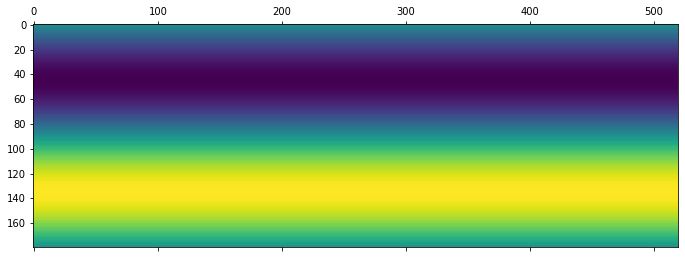

In [ ]:
plt.matshow(Setup()[3].transpose())

In [ ]:
print("All good?",(np.abs(np.max(Setup())-0.443377991)<1e-5) and ((np.abs(np.min(Setup())-0.0245774711)<1e-5)))

All good? True


### h. Putting it all together

🦉Write a function `Run(steps,record,n,n_init,obstacle)` (up in your function-cell) which takes
* the number of steps `steps` you want to run
* how often you want to `record` the velocity and density
* the microscopic densities `n` to start running from
* as well as the initial microscopic densities `n_init` for the boundary conditions (often equal to `n.copy()`)
* and the obstacle boolean array.

Each step consists of:
1. Adjust boundary conditions
2. Collide the microscopic densities
3. Move the microscopic densities

It should return
* a list of macroscopic densities `rhos`
* a list of macroscopic velocities `us`
    * This will be `u2=`$\sqrt{\vec{u}\cdot\vec{u}}$
    * To help us later, store these as `u2.transpose()`
* the last microscopic density `n`

Now (below) call your `Setup` and `Run` functions. Then plot the final configuration (something like `plt.matshow(us[-1])`).  

🦉Run for 201 steps recording every 100 steps.

#### Answer:

In [ ]:

def Run(steps, record, n, n_init, obstacle):
  rhos = []
  us = []
  nout = n
  nouts = []
  for step in range(steps):
    nout = FixBoundary(nout,n_init)
    nout = Collision(nout,obstacle)
    nout = Move(nout,obstacle)
    if step % record == 0:
      rho, u = Micro2Macro(nout)
      us.append(np.sqrt(np.einsum('ijk,ijk->jk',u,u).transpose()))
      rhos.append(rho)
      #nouts.append(nout)
      #us.append(u2)
  return rhos, us, nout

In [ ]:
#!Start
fin=Setup()
feq_init=fin.copy()
obstacle=GenerateCylinderObstacle()
#!Stop

In [ ]:
#!Start
fins=rhos=us= [None] * 21
fins[0]=fin.copy()
for i in range(0,20):
    (rhos[i],us[i],fins[i+1])=Run(200,10,fins[i],feq_init,obstacle)
#!Stop

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in add
  if __name__ == '__main__':


### i. Animation

🦉Now write a function `AnimateMe(us_flat,vMax)` which is going to take a list of velocities `us_flat` (and maximum for the `vMax`) and going to return an animation which is going to be then produced by calling
```python
anim = AnimateMe(us,vMax)
HTML(anim.to_jshtml())
```

This function will look like:
```python
def AnimateMe(us_flat,vMax):
    fig, ax = plt.subplots()
    cax = ax.imshow(us_flat[1],cmap=plt.cm.Reds,vmin=0,vmax=vMax)
    plt.close(fig)
    def animate(i):
         cax.set_array(us_flat[i])

    anim = FuncAnimation(fig, animate, interval=100, frames=len(us_flat))
    return anim
```



#### Answer:

In [ ]:
#!Start
def AnimateMe(us_flat,vMax):
    fig, ax = plt.subplots()
    cax = ax.imshow(us_flat[1],cmap=plt.cm.Reds,vmin=0,vmax=vMax)
    plt.close(fig)
    def animate(i):
         cax.set_array(us_flat[i])

    anim = FuncAnimation(fig, animate, interval=100, frames=len(us_flat))
    return anim
us_flat = list(itertools.chain.from_iterable(us[:-1]))
#us_flat = list(itertools.chain.from_iterable(us[0:17]))
anim=AnimateMe(us_flat,0.07)
HTML(anim.to_jshtml())
#!Stop

### j. Speed Test (EC)
*5 Points*

Our code for for `%time Run(2000,3000,Setup(),Setup(),GenerateCylinderObstacle())` takes between 45 and 60 seconds. We'll give 5 points if you can make your code faster than 40 seconds runtime (on the server). Warning: we aren't sure this is possible!

#### Answer:

## Exercise 2: Walls

* **List of collaborators:**

* **References you used in developing your code:**

In this exercise we are going to use all the same code but generate a different object.  Here generate an object which consists of two walls:
* one spans $50 \leq x \leq 60$ and $n_y/4 \leq y \leq 3n_y/4$
* the other spans $200 \leq x \leq 210$ and $n_y/4 \leq y \leq 3n_y/4$

🦉Run your code again with this new obstacle and generate a new animation.

#### Answer:

In [ ]:
def GenerateWallObstacle():
    obstacle=np.empty((nx,ny),dtype='bool')
    obstacle[:,:]=False
    for i in range(50, 60):
      for j in range(ny/4, ny/4*3+1):
        obstacle[i,j] = True
    for i in range(200, 210):
      for j in range(ny/4, ny/4*3+1):
        obstacle[i,j] = True
    return obstacle


In [ ]:
#!Start
fin=Setup()
feq_init=fin.copy()

obstacle=GenerateWallObstacle()
fins=rhos=us= [None] * 21
fins[0]=fin.copy()
for i in range(0,20):
    %time (rhos[i],us[i],fins[i+1])=Run(2000,100,fins[i],feq_init,obstacle)
#!Stop

In [ ]:
#!Start
us_flat = list(itertools.chain.from_iterable(us[0:-1]))
anim=AnimateMe(us_flat,0.2)
HTML(anim.to_jshtml())
#!Stop

## Exercise 3: Something new... (EC)
*(Extra credit: 5 points)*


* **List of collaborators:**

* **References you used in developing your code:**

🦉Come up with something new and cool to do with this animation code.  Maybe try out some other interesting obstacles are add some friction to the walls or such.

#### Answer:

**Acknowledgement:** This assignment originally inspired from code from flowkit.com
* Bryan Clark (original)


Copyright: 2021